<a href="https://colab.research.google.com/github/ariG23498/ImageRetrieval/blob/master/AutoEncoders_with_Supervision_for_Image_Retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports
The packages used are:
1. tensorflow
2. `tf.keras`
3. numpy
4. matplotlip
5. sklearn
6. scipy
7. random

In [ ]:
%%capture
!pip install wandb

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.model_selection import train_test_split

from scipy.special import comb
import random

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Data
We are using the CIFAR10 dataset here.

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])
X = X/255.

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.05)

170500096/170498071 [==============================] - 3s 0us/step


In [ ]:
y_train_encode = tf.keras.utils.to_categorical(y_train,num_classes=10)
y_test_encode = tf.keras.utils.to_categorical(y_test,num_classes=10)

In [ ]:
print('INFO X_train shape: {}'.format(X_train.shape))
print('INFO y_train shape: {}'.format(y_train.shape))
print('INFO y_train_encode shape: {}'.format(y_train_encode.shape))

print('INFO X_test shape: {}'.format(X_test.shape))
print('INFO y_test shape: {}'.format(y_test.shape))
print('INFO y_test_encode shape: {}'.format(y_test_encode.shape))

INFO X_train shape: (57000, 32, 32, 3)
INFO y_train shape: (57000, 1)
INFO y_train_encode shape: (57000, 10)
INFO X_test shape: (3000, 32, 32, 3)
INFO y_test shape: (3000, 1)
INFO y_test_encode shape: (3000, 10)


## Autoencoder

In [ ]:
def make_autoencoder(inputs):
  # 32,32,3
  x = tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  # 32,32,32
  x = tf.keras.layers.MaxPool2D()(x)
  # 16,16,32
  x = tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  # 16,16,64
  x = tf.keras.layers.MaxPool2D()(x)
  # 8,8,64
  tap = tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding='same',name='retrieval')(x)
  x = tf.keras.layers.BatchNormalization()(tap)
  x = tf.keras.layers.ReLU()(x)
  
  x = tf.keras.layers.UpSampling2D()(x)
  # 16,16,128
  x = tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  # 16,16,128
  x = tf.keras.layers.UpSampling2D()(x)
  # 32,32,128
  x = tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  # 32,32,64
  x = tf.keras.layers.Conv2D(filters=3,kernel_size=(3,3),activation='sigmoid',padding='same', name='auto_output')(x)

  return (tap,x)

## Dense

In [ ]:
def make_fc_network(inputs):
  x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
  x = tf.keras.layers.Dense(10,activation='softmax', name='fc_output')(x)
  return x

In [ ]:
tf.keras.backend.clear_session()
inputs = tf.keras.Input(shape=(32,32,3))

tap, auto_outputs = make_autoencoder(inputs)
fc_outputs = make_fc_network(tap)

model = tf.keras.Model(
			inputs=inputs,
			outputs=[auto_outputs, fc_outputs],
			name="combination"
			)
losses = {
	"auto_output": "mse",
	"fc_output": "categorical_crossentropy"
	}

model.compile(optimizer='adam', loss=losses)

In [ ]:
wandb.init(project="new_project", name="auto_with_supervision")
history = model.fit(
    x=X_train,
    y={"auto_output": X_train, "fc_output": y_train_encode},
    validation_split=0.2,
    epochs=10,
    callbacks=[WandbCallback()],
    use_multiprocessing=True
    )

Epoch 1/10
1425/1425 [==============================] - 15s 11ms/step - loss: 1.5745 - auto_output_loss: 0.0087 - fc_output_loss: 1.5657 - val_loss: 1.9143 - val_auto_output_loss: 0.0092 - val_fc_output_loss: 1.9051
Epoch 2/10
1425/1425 [==============================] - 15s 10ms/step - loss: 1.3230 - auto_output_loss: 0.0070 - fc_output_loss: 1.3160 - val_loss: 1.4726 - val_auto_output_loss: 0.0069 - val_fc_output_loss: 1.4657
Epoch 3/10
1425/1425 [==============================] - 15s 11ms/step - loss: 1.2204 - auto_output_loss: 0.0065 - fc_output_loss: 1.2139 - val_loss: 1.6143 - val_auto_output_loss: 0.0074 - val_fc_output_loss: 1.6069
Epoch 4/10
1425/1425 [==============================] - 15s 10ms/step - loss: 1.1537 - auto_output_loss: 0.0061 - fc_output_loss: 1.1476 - val_loss: 1.4766 - val_auto_output_loss: 0.0060 - val_fc_output_loss: 1.4707
Epoch 5/10
1425/1425 [==============================] - 15s 11ms/step - loss: 1.1053 - auto_output_loss: 0.0058 - fc_output_loss: 1.0995

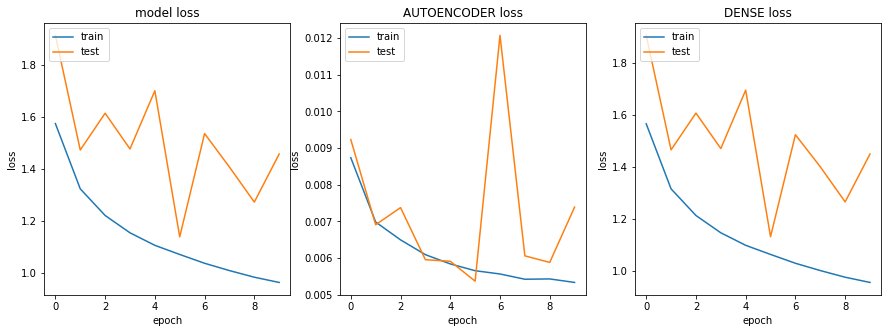

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,3,2)
plt.plot(history.history['auto_output_loss'])
plt.plot(history.history['val_auto_output_loss'])
plt.title('AUTOENCODER loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,3,3)
plt.plot(history.history['fc_output_loss'])
plt.plot(history.history['val_fc_output_loss'])
plt.title('DENSE loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Test Images


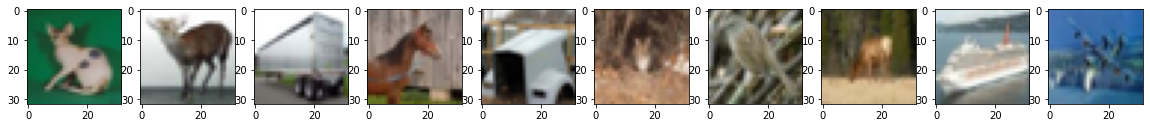

Reconstruction of Test Images


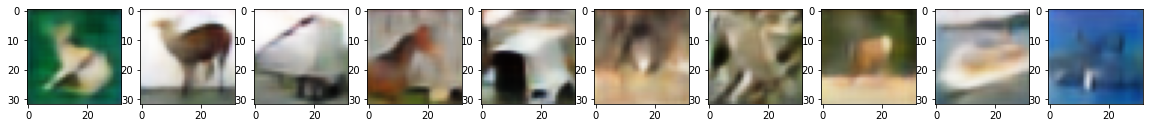

In [ ]:
auto_pred, fc_pred = model.predict(X_test)
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_test[i])
    curr_lbl = y_test[i]
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(auto_pred[i])  
plt.show()

In [ ]:
layer_name = 'retrieval'
slice_model = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer(layer_name).output
    )

In [ ]:
pred = slice_model.predict(X_train)
pred.shape

(57000, 8, 8, 128)

In [ ]:
pred = tf.keras.layers.GlobalAveragePooling2D()(pred)
pred.shape

TensorShape([57000, 128])

In [ ]:
pred_embedded = TSNE(n_components=2).fit_transform(pred)
pred_embedded.shape

(57000, 2)

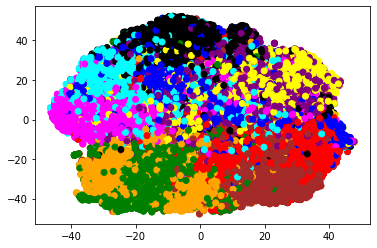

In [ ]:
colors = ['red','green','blue','purple','cyan', 'yellow', 'black', 'magenta','brown','orange']
plt.scatter(
    pred_embedded[:,0],
    pred_embedded[:,1],
    c=y_train,
    cmap=matplotlib.colors.ListedColormap(colors)
    )

plt.savefig('t-sne.png')
wandb.log({'t-sne': wandb.Image('t-sne.png')})

plt.show()

In [ ]:
classifier = KMeans(n_clusters=10, random_state=0).fit(pred)
classifier.labels_.shape 

(57000,)

In [ ]:
nmis = normalized_mutual_info_score(y_train.reshape(-1), classifier.labels_)
nmis

0.43357735134829617

In [ ]:
def rand_index_score(clusters, classes):
    tp_plus_fp = comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

In [ ]:
ri_supervision = rand_index_score (y_train.reshape(-1), classifier.labels_)
ri_supervision

0.8769812428226658

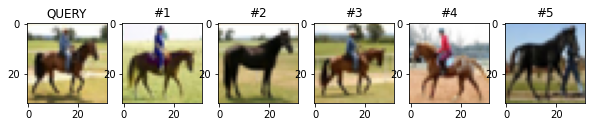

In [ ]:
# Take a random image from the test set
idx = random.randint(0,X_test.shape[0])
query = X_test[idx]
label = y_test[idx]

# Retrieve the embedding for the query image
query_embed = slice_model.predict(query[np.newaxis,:,:,:])
query_embed = tf.keras.layers.GlobalAveragePooling2D()(query_embed)

# Predict the label from the clusters
pred_label = classifier.predict(query_embed)

# Retrive the train images of the particular cluster
idx_cluster = classifier.labels_ == pred_label[0]

image_cluster = X_train[idx_cluster]
cluster = pred[idx_cluster]

# Basic euclidean
diff = cluster - query_embed
diff_sq = np.square(diff)
dis = np.sum(diff_sq, axis=1)

# Top five images
top_five_images = image_cluster[np.argsort(dis)[:5]]
top_five_images.shape

# Plot the result
plt.figure(figsize=(10,10))
plt.subplot(1,6,1)
plt.imshow(query)
plt.title('QUERY')
for i in range(1,6):
  plt.subplot(1,6,i+1)
  plt.imshow(top_five_images[i-1])
  plt.title('#{}'.format(i))
plt.show()